#Install & Import Libraries


In [1]:
!pip3 install pydub
!pip3 install xmltodict
!pip3 install resemblyzer
!pip3 install pyannote.core
!pip3 install noisereduce
!pip3 install pyannote.metrics
!pip3 install spectralcluster

     |████████████████████████████████| 15.7MB 290kB/s 
     |████████████████████████████████| 71kB 8.0MB/s 
     |████████████████████████████████| 81kB 8.2MB/s 
  Created wheel for webrtcvad: filename=webrtcvad-2.0.10-cp37-cp37m-linux_x86_64.whl size=72315 sha256=fb506fd7396bad50338cd73dfa09532056af721258dcdf6c55b341142fda579e
  Stored in directory: /root/.cache/pip/wheels/44/2a/18/bd1aec41cac7c3051fe95d92a6ed446122ea31dc713c432fa1
  Created wheel for typing: filename=typing-3.7.4.3-cp37-none-any.whl size=26308 sha256=db2ef5476894a9d45481bd838bfd0398e2c46f623ce41621b52125be587e8d37
  Stored in directory: /root/.cache/pip/wheels/2d/04/41/8e1836e79581989c22eebac3f4e70aaac9af07b0908da173be
Successfully built webrtcvad typing


     |████████████████████████████████| 61kB 4.9MB/s 
     |████████████████████████████████| 133kB 8.1MB/s 
  Created wheel for noisereduce: filename=noisereduce-1.1.0-cp37-none-any.whl size=7610 sha256=1f964b7a551676227b459d89f6c87f831dfcf1d671bf9a14aa0e1779cb3991b2
  Stored in directory: /root/.cache/pip/wheels/a6/2c/70/f9ccb41280dcfbe3eaeb7930f913dd85394617f3d3136f29cc
Successfully built noisereduce
     |████████████████████████████████| 51kB 4.1MB/s 
     |████████████████████████████████| 51kB 6.1MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [12]:
from pydub import AudioSegment
import xmltodict
import os

from resemblyzer import VoiceEncoder, preprocess_wav
from pathlib import Path
import numpy as np

from operator import itemgetter
from lxml import etree
import xml.etree.ElementTree as ET
import json

import librosa
import matplotlib.pyplot as plt
import librosa.display
from IPython.display import Audio, display
from math import ceil

from pyannote.core import Segment, Timeline, Annotation, notebook
from pyannote.metrics.diarization import DiarizationErrorRate, GreedyDiarizationErrorRate, JaccardErrorRate
import noisereduce as nr
from tqdm import tqdm

import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.decomposition import PCA

from spectralcluster import SpectralClusterer

import matplotlib
from matplotlib import style
import datetime

from sklearn.cluster import SpectralClustering

#Data Preprocessing + Embedding Generation





### Parse XML Files and Spit Wav File into Chunks


In [4]:
def parse_ami_transcript_xml(file, speaker_id):
    """
    Parsing AMI transcript XML file
    """
    xmlp = ET.XMLParser(encoding="ISO-8859-1")
    f = ET.parse(file, parser=xmlp)
    root = f.getroot()
    transcript = []
    for element in list(root):
        if element.tag == 'w':
            if element.text:
                text = element.text
            else:
                text = ''
            if element.get('punc'):
                punc = True
            else:
                punc = False

            transcript.append({
                'start': float(element.get('starttime')),
                'end': float(element.get('endtime')),
                'text': text,
                'punc': punc,
                'speaker_id': speaker_id
            })
    previous = transcript[0]
    for index, elem in enumerate(transcript):
        if elem['start'] == previous['end']:
            previous['end'] = elem['end']
            previous['text'] += ('' if elem['punc'] else ' ') + elem['text']
            transcript[index] = None
        else:
            del elem['punc']
            previous = elem
    transcript = [t for t in transcript if t and len(t['text'])]
    return transcript

def split_wav(directory_path,filename,t1,t2, chunk_id):
  t1=float(t1)*1000
  t2=float(t2)*1000
  complete_file_path = os.path.join(directory_path, filename)
  audio_file = AudioSegment.from_wav(complete_file_path)
  audio_file = audio_file[t1:t2]
  audio_file.export(complete_file_path.replace('.wav','')+f'_{chunk_id}.wav', format = 'wav')

def parse_xml(directory_path, filename):
  complete_file_path = os.path.join(directory_path, filename)
  content = open(complete_file_path).read()
  return xmltodict.parse(content)

In [5]:
###################### PATH TO CORPUS & AUDIO FOLDER ######################
AMI_CORPUS_FOLDER = './drive/MyDrive/ATML/ami_public_manual_1.6.2/words'
AMI_AUDIO_FOLDER = './drive/MyDrive/ATML/amicorpus/'
SPEAKERS = ['A', 'B', 'C', 'D']

###Read Training Data + Make Embeddings

In [6]:
X = []
y = []
X_withoutEmbedding = []
startEndTime = []
def read_xml_and_split(RECORDING_ID):
  speakers_phrases = []
  for index, speaker in enumerate(SPEAKERS):
      t = parse_ami_transcript_xml(f"{AMI_CORPUS_FOLDER}/{RECORDING_ID}.{speaker}.words.xml", index)
      speakers_phrases.extend(t)
  final = sorted(speakers_phrases, key=itemgetter('start'))
  print(final)

  encoder = VoiceEncoder()

  for i,d in enumerate(final):
    speaker = d['speaker_id']
    split_wav(os.path.join(AMI_AUDIO_FOLDER,RECORDING_ID,'audio'),f'{RECORDING_ID}.Mix-Headset.wav',d['start'],d['end'],f'{speaker}_{i}')
    wav = preprocess_wav(os.path.join(AMI_AUDIO_FOLDER,RECORDING_ID,'audio',f'{RECORDING_ID}.Mix-Headset_{speaker}_{i}.wav'))
    embed = encoder.embed_utterance(wav)
    X_withoutEmbedding.append(wav)
    X.append(embed)
    y.append(speaker)
    startEndTime.append([d['start'],d['end']])
    
read_xml_and_split('ES2002a')

[{'start': 50.42, 'end': 50.99, 'text': 'Okay.', 'speaker_id': 1}, {'start': 53.56, 'end': 53.96, 'text': 'Right.', 'speaker_id': 1}, {'start': 55.98, 'end': 77.29, 'text': "Um well this is the kick-off meeting for our our project. Um and um this is just what we're gonna be doing over the next twenty five minutes. Um so first of all, just to kind of make sure that we all know each other, I'm Laura and I'm the project manager. Do you want to introduce yourself again?", 'speaker_id': 1}, {'start': 67.21, 'end': 67.45, 'text': 'Mm-hmm.', 'speaker_id': 3}, {'start': 74.89, 'end': 75.24, 'text': 'Great.', 'speaker_id': 3}, {'start': 77.44, 'end': 80.87, 'text': "Hi, I'm David and I'm supposed to be an industrial designer.", 'speaker_id': 0}, {'start': 80.81, 'end': 81.26, 'text': 'Okay.', 'speaker_id': 1}, {'start': 82.08, 'end': 84.46, 'text': "And I'm Andrew and I'm uh our marketing", 'speaker_id': 3}, {'start': 85.99, 'end': 88.71, 'text': "Um I'm Craig and I'm User Interface.", 'speaker

###Generate Test Data + Make Embeddings

In [7]:
X_test = []
y_test = []
y_test_ref = [] 
X_withoutEmbedding_test = []
startEndTime_test = []
startEndTime_test_ref = []

def testDataGeneration(RECORDING_ID):
  speakers_phrases = []
  for index, speaker in enumerate(SPEAKERS):
      t = parse_ami_transcript_xml(f"{AMI_CORPUS_FOLDER}/{RECORDING_ID}.{speaker}.words.xml", index)
      speakers_phrases.extend(t)
  final = sorted(speakers_phrases, key=itemgetter('start'))
  print(final)

  for i in range(len(final)):
    speaker = final[i]['speaker_id']
    startEndTime_test_ref.append([final[i]['start'],final[i]['end']])
    y_test_ref.append(speaker)

  for i in range(len(final)-1):
    if(final[i]['end']>final[i+1]['start']):
      final[i]['end']=final[i+1]['start']

  encoder = VoiceEncoder()

  for i in range(len(final)):
    speaker = final[i]['speaker_id']
    for j in range(int(final[i]['end']-final[i]['start'])):
      split_wav(os.path.join(AMI_AUDIO_FOLDER,RECORDING_ID,'audio'),f'{RECORDING_ID}.Mix-Headset.wav',final[i]['start']+j,final[i]['start']+j+1,f'{speaker}_{i}_{j}')
      wav = preprocess_wav(os.path.join(AMI_AUDIO_FOLDER,RECORDING_ID,'audio',f'{RECORDING_ID}.Mix-Headset_{speaker}_{i}_{j}.wav'))
      embed = encoder.embed_utterance(wav)
      X_withoutEmbedding_test.append(wav)
      X_test.append(embed)
      y_test.append(speaker)
      startEndTime_test.append([final[i]['start']+j,final[i]['start']+j+1])

testDataGeneration('ES2002a')

[{'start': 50.42, 'end': 50.99, 'text': 'Okay.', 'speaker_id': 1}, {'start': 53.56, 'end': 53.96, 'text': 'Right.', 'speaker_id': 1}, {'start': 55.98, 'end': 77.29, 'text': "Um well this is the kick-off meeting for our our project. Um and um this is just what we're gonna be doing over the next twenty five minutes. Um so first of all, just to kind of make sure that we all know each other, I'm Laura and I'm the project manager. Do you want to introduce yourself again?", 'speaker_id': 1}, {'start': 67.21, 'end': 67.45, 'text': 'Mm-hmm.', 'speaker_id': 3}, {'start': 74.89, 'end': 75.24, 'text': 'Great.', 'speaker_id': 3}, {'start': 77.44, 'end': 80.87, 'text': "Hi, I'm David and I'm supposed to be an industrial designer.", 'speaker_id': 0}, {'start': 80.81, 'end': 81.26, 'text': 'Okay.', 'speaker_id': 1}, {'start': 82.08, 'end': 84.46, 'text': "And I'm Andrew and I'm uh our marketing", 'speaker_id': 3}, {'start': 85.99, 'end': 88.71, 'text': "Um I'm Craig and I'm User Interface.", 'speaker

In [8]:
X = np.array(X)
X_test = np.array(X_test)
y = np.array(y)

# Cluster Plot of Embeddings

####PCA for Dataset Emebeddings (with True Labels)


In [9]:
def preprocessingX(X):
  # Preprocessing the data to make it visualizable 
  raw_df = pd.DataFrame(X)  

  # Scaling the Data 
  scaler = StandardScaler() 
  X_scaled = scaler.fit_transform(raw_df) 

  # Normalizing the Data 
  X_normalized = preprocessing.normalize(X_scaled) 

  # Converting the numpy array into a pandas DataFrame 
  X_normalized = pd.DataFrame(X_normalized) 

  # Reducing the dimensions of the data 
  pca = PCA(n_components = 2) 
  X_principal = pca.fit_transform(X_normalized) 
  X_principal = pd.DataFrame(X_principal) 
  X_principal.columns = ['P1', 'P2'] 
  return X_principal 

In [10]:
X_principal = preprocessingX(X)
X_principal_test = preprocessingX(X_test)
X_principal.head(2)

,P1,P2
0,0.270508,-0.477588
1,0.543774,-0.434460


###Plot of Spectral Clustering When exact number of speakers known


###Using Radial Basis Function 


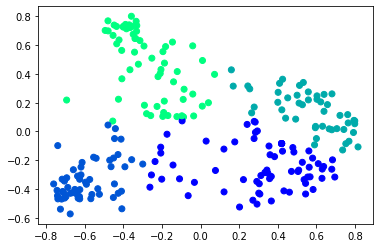

In [13]:
# Building the clustering model 
spectral_model_rbf = SpectralClustering(n_clusters = 4, affinity ='rbf') 
  
# Training the model and Storing the predicted cluster labels 
labels_rbf = spectral_model_rbf.fit_predict(X_principal)

# Visualizing the clustering
plt.scatter(X_principal['P1'], X_principal['P2'],c = SpectralClustering(n_clusters = 4, affinity ='rbf') .fit_predict(X_principal), cmap =plt.cm.winter) 
plt.show() 

####Using Nearest Neighbours function

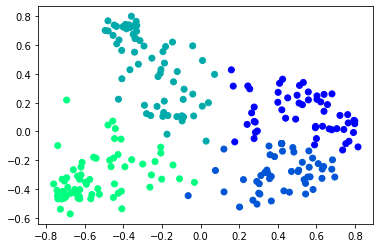

In [14]:
# Building the clustering model 
spectral_model_nn = SpectralClustering(n_clusters = 4, affinity ='nearest_neighbors') 
  
# Training the model and Storing the predicted cluster labels 
labels_nn = spectral_model_nn.fit_predict(X_principal)

# Visualizing the clustering 
plt.scatter(X_principal['P1'], X_principal['P2'],c = SpectralClustering(n_clusters = 4, affinity ='nearest_neighbors') .fit_predict(X_principal), cmap =plt.cm.winter) 
plt.show() 

###Plot of Spectral Clustering When number of speaker not known beforehand


### Scatter Plot with True Labels as color vector (4 clusters -> 4 speakers)

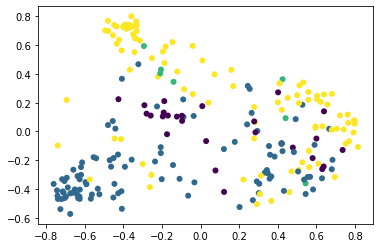

In [15]:
c = np.random.choice(range(4), 100)
# plot the data
fig = plt.figure()
ax = fig.add_subplot(111)
# plot x,y data with c as the color vector, set the line width of the markers to 0
ax.scatter(X_principal['P1'], X_principal['P2'], c=y, lw=0)

### Scatter Plot with Predicted Labels as color vector (2 clusters -> 2 speakers predicted)

In [16]:
########## Define Spectral Clusterer with their arguments #############
clusterer = SpectralClusterer(
    min_clusters=2,
    max_clusters=100,
    p_percentile=0.95,
    gaussian_blur_sigma=.5)

labels = clusterer.predict(X)
labels_test = clusterer.predict(X_test)

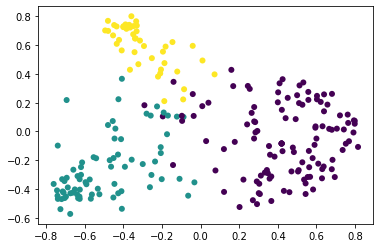

In [17]:
#Train
c = np.random.choice(range(4), 100)
# plot the data
fig = plt.figure()
ax = fig.add_subplot(111)
# plot x,y data with c as the color vector, set the line width of the markers to 0
ax.scatter(X_principal['P1'], X_principal['P2'], c=labels, lw=0)


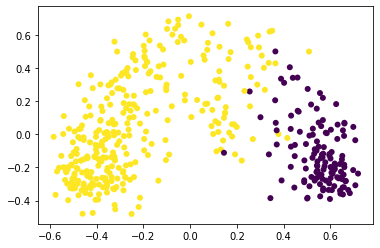

In [18]:
# Test
# plot the data
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(X_principal_test['P1'], X_principal_test['P2'], c=labels_test, lw=0)

In [19]:
def get_hypothesis(speaker_segments):
    hypothesis = Annotation()
    for t in speaker_segments:
        try:
            hypothesis[Segment(t['start'], t['end'])] = f"{t['speaker_id']}_hyp"
        except:
            pass
        
    return hypothesis

def get_ref(speaker_segments):
    reference = Annotation()
    for t in speaker_segments:
        try:
            reference[Segment(t['start'], t['end'])] = f"{t['speaker_id']}_ref"
        except:
            pass
        
    return reference

der = DiarizationErrorRate()
gder = GreedyDiarizationErrorRate()
jer = JaccardErrorRate()

def measure_metrics(reference, hypothesis):
    der_value = der(reference, hypothesis)
    print('DER:', der_value)
    return der_value

def ref_hypo(startEndTime,startEndTime_ref,labels,y):
  speaker_segments = []
  for i in range(len(startEndTime)):
    speaker_segments.append({
                        'start': startEndTime[i][0],
                        'end': startEndTime[i][1],
                        'speaker_id': labels[i]
                    })
  speaker_segments_ref = []
  for i in range(len(startEndTime_ref)):
    speaker_segments_ref.append({
                        'start': startEndTime_ref[i][0],
                        'end': startEndTime_ref[i][1],
                        'speaker_id': y[i]
                    })
  return speaker_segments,speaker_segments_ref

In [20]:
speaker_segments,speaker_segments_ref = ref_hypo(startEndTime,startEndTime,labels,y)

speaker_segments_test,speaker_segments_ref_test = ref_hypo(startEndTime_test,startEndTime_test_ref,labels_test,y_test_ref)



In [21]:
########## TRAIN #############

hypothesis = get_hypothesis(speaker_segments)
reference = get_ref(speaker_segments_ref)
der_value = measure_metrics(reference, hypothesis)

########## TEST #############
hypothesis_test = get_hypothesis(speaker_segments_test)
reference_test = get_ref(speaker_segments_ref_test)
der_value = measure_metrics(reference_test, hypothesis_test)

/usr/local/lib/python3.7/dist-packages/pyannote/metrics/utils.py:184: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  "'uem' was approximated by the union of 'reference' "


DER: 0.14645075072714417
DER: 0.5575931811290675


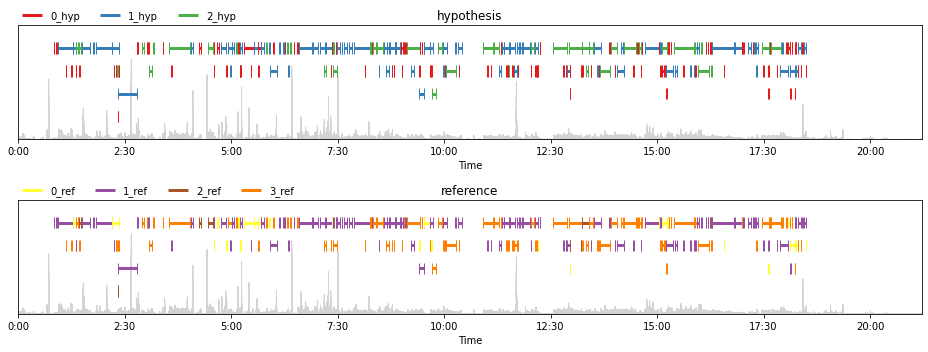

In [22]:
def timeTicks(x, pos):
    d = datetime.timedelta(seconds=x)
    return str(d)[-5:] if x < 3600 else str(d)
formatter = matplotlib.ticker.FuncFormatter(timeTicks)

SR = 32000

def plot_der(FILEPATH,reference,hypothesis):
    fig = plt.figure(figsize=(13, 5))

    # plot hypothesis
    ax = plt.subplot(211)
    plt.title('hypothesis')
    ax.xaxis.set_major_formatter(formatter)
    wav, source_sr = librosa.load(FILEPATH, sr=SR)
    ticks_freq = ceil(len(wav) * .1 / source_sr)

    notebook.plot_annotation(hypothesis, legend=True, time=True)
    librosa.display.waveplot(wav, sr=source_sr, color='lightgray')

    # plot reference
    ax = plt.subplot(212)
    plt.title('reference')
    ax.xaxis.set_major_formatter(formatter)

    notebook.plot_annotation(reference, legend=True, time=True)
    librosa.display.waveplot(wav, sr=source_sr, color='lightgray')

    plt.margins(x=0.01)
    plt.tight_layout()
    plt.show()

%matplotlib inline

plot_der(os.path.join(os.path.join(AMI_AUDIO_FOLDER,'ES2002a','audio'),'ES2002a.Mix-Headset.wav'),reference,hypothesis)


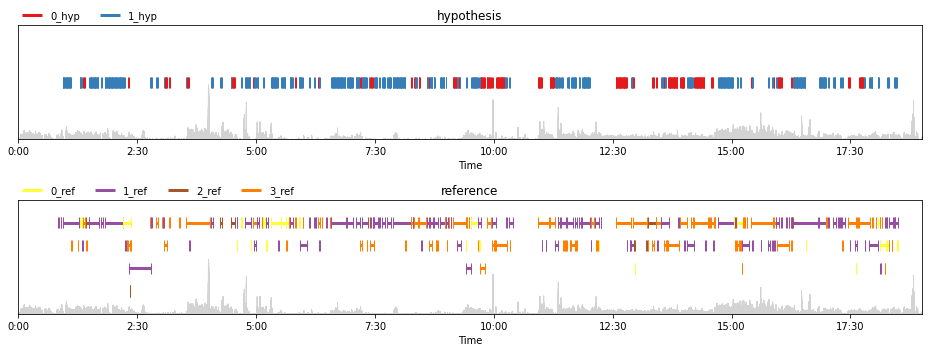

In [23]:
plot_der(os.path.join(os.path.join(AMI_AUDIO_FOLDER,'ES2003a','audio'),'ES2003a.Mix-Headset.wav'),reference_test,hypothesis_test)